[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epiasini/bmitns/blob/main/lecture_5/Binary-classification.ipynb)

In [1]:
%%capture
!pip install numpy scipy matplotlib ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [2]:
import numpy as np
import scipy
from scipy.stats import norm, binom
from matplotlib import pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

# Description of the experiment
We perform a classification experiment, where the stimulus $s$ could belong to one of two classes (which we call $1$ and $0$ by convention). For instance, we may show to the subject an oriented grating of variable orientation $s$, and we ask the subject to report whether the grating is oriented to the left $s<0$ or to the right $s>0$.

<img src='grating.png' width="100">

In the lab, we perform $N$ trials and for each trial $t$ we record:
- the true value of the stimulus, $s_t$ (which is known to us, - we are the ones generating the stimulus, so we know its true value
- the class reported by the subject, $\hat{c}_t$. We can indicate our experimental dataset $\mathcal{D}$ with the notation $\mathcal{D}=\left\{(s_t,\hat{c}_t)\right\}_{t=1}^N$.

# Building the model
To build our model of perception we make the following assumptions:
- the **prior** is flat: $p(c=1) = p(c=0) = 1/2$
- the **class-conditional stimulus densities** (CCSD) are mirror-symmetric: $p(s|c=0) = p(-s|c=1)$. A simple case satisfying this condition is when $c=1$ means that $s$ is sampled uniformly from a set of possible positive values $0 < s_1 < s_2, \ldots, S_K$, and $c=0$ means that $s$ is sampled uniformly from the set of corresponding negative values: $0 > -s_1 > -s_2 > \ldots > -S_K$, like in the figure below. For concreteness, this is the case we will use in this notebook.

<img src='ccsd_discrete.png' width="400">.

However, the results don't change as long as the CCSDs maintain the same symmetry, like these ones:

<img src='ccsd_skewed_gaussian.png' width="400">

- the **measurement distribution**/likelihood function is, as usual, Gaussian: $p(x|s) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[\frac{-(x-s)^2}{2\sigma^2}\right]$

By applying our usual method, we have built a model of the perceptual process, and we have solved it to obtain the **response distribution**:

$$
p(\hat{c}|s) = \Phi\left(\frac{s}{\sigma}\right) = \int_{-\infty}^s ds' \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{s'^2}{2\sigma^2}\right]
$$
where $\Phi(z)$ is the cumulative Gaussian function (the integral of a Gaussian pdf from $-\infty$ to z).

# Fitting the model
Our model has a free parameter, $\sigma$, representing the sensory noise. This parameter is unknown, and we wish to estimate it based on the data we have recorded in the lab. There are many ways of doing this, but the most common is to **perform a maximum-likelihood fit**. 

We start by defining the likelihood of our model,
$$
\mathcal{L}(\sigma) = p(\mathcal{D}|\sigma)
$$
Note that **this is just a measure of the degree to which the model describes the data; it is not directly related to any of the functions we used to build the Bayesian model that culminated in the response distribution** (although of course it is derived from them, and has an analogous mathematical role). When we built the model, we also had a likelihood function $p(x|s)$, the likelihood for one value of the stimulus $s$ after observing the *measurement* $x$. These are completely different objects: $p(x|s)$ is related to the inference process that the **subject** performs to estimate the stimulus $s$ from the measurement $x$ in an experimental trial, while $p(\mathcal{D}|\sigma)$ is related to the inference process that the **experimenter** performs to estimate $\sigma$ from the data $\mathcal{D}$ collected during the course of the experiment.

The model likelihood is simply, by definition, the probability of observing the data we have observed, given a particular value of $\sigma$. If we had only observed a single trial, with stimulus $s$, this would be:
- $\mathcal{L}(\sigma) = p(\hat{c}=1|s)$ if the subject response on that trial was $\hat{c}=1$, or 
- $\mathcal{L}(\sigma) = p(\hat{c}=0|s) = 1-p(\hat{c}=1|s)$ if the response was $\hat{c}=0$.

However, our dataset $\mathcal{D}$ is composed by many trials. Since each trial is statistically independent, to obtain the probability of observing all of them we can simply multiply the probabilities calculated for each individual trial. To do so, we divide them in two different sets, the set of trials where the response was $\hat{c}=1$ and the set of trials where the response was $\hat{c}=0$. We get:

$$
\mathcal{L}(\sigma) = p(\mathcal{D}|\sigma) = \prod_{t:\hat{c}_t=1}p(\hat{c}=1|s_t) \times \prod_{t:\hat{c}_t=0}p(\hat{c}=0|s_t)\\
 = \prod_{t:\hat{c}_t=1}p(\hat{c}=1|s_t) \times \prod_{t:\hat{c}_t=0}\left[1-p(\hat{c}=1|s_t)\right]
$$

Now we use a trick: remembering that, for any $x$, $x^1=x$ and $x^0=1$, we can re-write this product as

$$
\mathcal{L}(\sigma) = \prod_{t=1}^N p(\hat{c}=1|s_t)^{\hat{c}_t} \times \left[1-p(\hat{c}=1|s_t)\right]^{(1-\hat{c}_t)}\\
= \prod_{t=1}^N \Phi\left(\frac{s_t}{\sigma}\right)^{\hat{c}_t} \times \left[1-\Phi\left(\frac{s_t}{\sigma}\right)\right]^{(1-\hat{c}_t)}
$$

This is because on the trials where $\hat{c}_t=1$ the second term of the product above will be raised to the zeroth power (if $\hat{c}_t=1$, then $1-\hat{c}_t=0$) and therefore it will not contribute to the product - again, because anything raised to the zeroth power is 1 and multiplying anything by 1 does not make any difference. Conversely, on the trials where $\hat{c}_t=0$ the first term of the product will not contribute, leaving only the second.

Now we have our likelihood function, which depends on $\sigma$ through the fact that the response distribution $p(\hat{c}=1|s)$ depends on $\sigma$ (remember, $p(\hat{c}=1|s)=\Phi(s/\sigma))$. We want to find the value of $\sigma$ that maximises $\mathcal{L}$. Before doing so, for convenience we take the logarithm of the likelihood (this makes no difference in terms of maximising the function). Remembering the general property of the logarithm that

$$
\ln (a^c\cdot b^d) = c\ln(a) + d\ln(b)
$$

we can write our **log likelihood** as

$$
\ln \mathcal{L}(\sigma) = \sum_{t=1}^N\left[\hat{c}_t\ln p(\hat{c}=1|s_t) + \left(1-\hat{c}_t\right)\ln\left(1-p(\hat{c}=1|s_t)\right)\right]\\
 = \sum_{t=1}^N\left[\hat{c}_t\ln \Phi(s_t/\sigma) + \left(1-\hat{c}_t\right)\ln\left(1-\Phi(s_t/\sigma)\right)\right]
$$

At this point we are done. In the expression above, $\Phi$ is a known function, implemented in any language, and $s_t$ and $\hat{c}_t$ are what makes up our experimental data. The only unknown is $\sigma$. We can then **plug this function into any numerical optimization algorithm** (which you can find built-in into all scientific/data oriented languages and packages, Python/Julia/R/Matlab...) **to find the value of $\sigma$ that maximises $\mathcal{L}$**.

Now, this is a sum over all trials. We can simplify this expression further if we use the assumption that $s$ can have only a finite number of values, $s=-s_K, -s_{K-1},\ldots,-s_{1}, s_1, s_2, \ldots, s_{K-1}, s_K$. If this is the case, we can break up the sum into $2K$ smaller sums, each running over all trials that had a given value of $s$.

$$
\ln \mathcal{L}(\sigma) = \sum_{s=-s_k}^{s_K}\sum_{t:s_t=s} \left[\hat{c}_t\ln p(\hat{c}=1|s) + \left(1-\hat{c}_t\right)\ln\left(1-p(\hat{c}=1|s)\right)\right]
$$

Now, if we define:
- $n_s$ = number of trials where the stimulus was $s$
- $l_s$ = number of trials where the stimulus was $s$ **and** the response was $\hat{c}=1$
we get:

$$
\ln \mathcal{L}(\sigma) = \sum_{s=-s_K}^{s_K} \left[l_s \ln p(\hat{c}=1|s) + (n_s-l_s) \ln\left(1-p(\hat{c}=1|s)\right)\right] \\
= \sum_{s=-s_K}^{s_K} \left[l_s \ln \Phi(s/\sigma) + (n_s-l_s) \ln\left(1-\Phi(s/\sigma)\right) \right] \\
$$

which is a very simple expression depending only on the stimulus values $s$ and the **counts** of how many trials there were for that stimulus values and in how many of those trials the subject reported $c=1$. And of course on $\sigma$, as the only free parameter of our model. Again, we can now take this expression and feed it to some optimization algorithm to find numerically the value of $\sigma$ that gives the largest $\ln \mathcal{L}(\sigma)$.

## Extra: an alternative derivation
We note that we can arrive at the expression above by an alternative, more direct path, assuming that we are already familiar with the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Our model says that every time that we ask the subject to classify stimulus $s$, the subject will report $\hat{c}=1$ with a given probability $p(\hat{c}=1|s)=\Phi(s/\sigma)$. We have also assumed that there are $n_s$ trials for each level of the stimulus $s$, and that the subject has actually reported $\hat{c}=1$ in $l_s$ of them. We can recognize this as the description of a **binomial process**, where the number of "successes" $l_s$ at each level depends on the number of attempts $n_s$ and the probability of success $p(\hat{c}=1|s)$. If we define a new dataset

$$\mathcal{D}'=\left\{(n_s, l_s)\right\}_{s=-s_K}^{s_K}$$

(where the data is the same as in the original $\mathcal{D}$, but we represent it as a series of counts instead of a series of stimulus-report pairs), then we can directly write likelihood of the model with respect to this dataset as a product of binomial likelihoods (one per level of the stimulus):

$$
p(\mathcal{D}'|\sigma) = \prod_{s=-s_K}^{s_K}\binom{n_s}{l_s}\left[p(\hat{c}=1|s)\right]^{l_s}\left[1-p(\hat{c}=1|s)\right]^{n_s-l_s}
$$

Unsurprisingly, if we take the log we find that this likelihood is closely related to the one we derived above:

$$
\ln p(\mathcal{D}'|\sigma) = \ln p(\mathcal{D}|\sigma) + \sum_s \ln\binom{n_s}{l_s}
$$

<font color=red>**Question/exercise:**</font> where does this difference come from, conceptually? How come we have two different likelihoods for the same data and the same model? Does it matter which one we use to find the best value of $\sigma$ for the data?

# Simulation
Now we create a simulated experiment. An instance of the experiment is defined by a true value for $\sigma$ and a value of the total number $N$ of trials in the experiment (other parameters such as the values taken by the stimulus $s$ are hardcoded below for simplicity). With rather poor coding practice, we encapsulate everything into a function `plot_psychometric` that generates the simulated data, fits the ideal observer to obtain an estimate of $\sigma$ from the data, and then makes a plot showing the "ground truth" psychometric, the simulated data, and the fitted psychometric.

Note that this is a key advantage of our modeling framework: our Bayesian models of perception are **generative models**. They allow our experiment + analysis to be tested out in simulation before we collect any data in the lab.

In [3]:
def log_likelihood(σ, choice_1_counts, s_levels, n_trials_per_levels):
    l_s = choice_1_counts
    s = s_levels
    n_s = n_trials_per_levels
    # In principle, the following is the definition as per the expressions derived above.
    #     However, scipy provides a special function to compute "log of a cumulative gaussian",
    #     which is a bit better from a numerical standpoint than just writing np.log(norm.cdf(...)).
    #     So we comment out the "literal" implementation of our likelihood, and use the more
    #     sophisticated one instead.
    # return (l_s*np.log(norm.cdf(s/σ)) + (n_s-l_s)*np.log(1-norm.cdf(s/σ))).sum()
    return (l_s*scipy.special.log_ndtr(s_levels/σ) + (n_s-l_s)*scipy.special.log_ndtr(-s/σ)).sum()

In [4]:
def plot_psychometric(σ, N, display_behavioral_variance):
    
    # values of s to be used
    s_levels = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    # relative amount of trials to be allocated to each level. By default this is uniform (all numbers are equal),
    #     but you can try changing it to see what happens. Note that if you "weigh" one stimulus level
    #     a lot by putting more trials there than in other levels, the fit will automatically value that
    #     datapoint more than the others, trying to make the fitted curve approach more the data at that point.
    #     This is very useful, as often in the lab one ends up with more data in certain conditions than others.
    trial_distribution = np.array([1,1,1,1,1,1,1,1,1])
    # number of trials per level of the stimulus. This is just the total number N, divided among the
    #     levels according to the ratios in trial_distributions above.
    n_trials_per_level = (N*trial_distribution/trial_distribution.sum()).round().astype('int')
    
    # compute probability of choosing category c=+1 for each stimulus level in the experiment
    p = norm.cdf(s_levels/σ)
    
    # generate empirical data: for each level, sample n_trials_per_level choices from a Binomial distribution
    l = binom.rvs(n_trials_per_level, p)
    
    # fit empirical data with psychometric function. Note that our optimization library
    #     can find *minima*, not *maxima* of functions, so instead of directly maximising
    #     the log-likelihood we minimize the "minus log likelihood" (which is the same).
    def function_to_be_minimized(σ):
        return -log_likelihood(σ, l, s_levels, n_trials_per_level)
    
    # x0 here is an "initial guess" for the value of σ, needed for the optimization
    #     procedure. The results should be robust to this choice. "bounds" is needed to
    #     tell the optimizer that it shouldn't try negative values of σ.
    σ_fit = scipy.optimize.minimize(function_to_be_minimized, x0=[0.5], bounds=[(0.01, None)]).x[0]
    
    # plot theoretical psychometric function
    fig, ax = plt.subplots(figsize=(8,6))
    s_plot_range = np.linspace(s_levels.min(), s_levels.max(), 100)
    p_plot = norm.cdf(s_plot_range/σ)
    ax.plot(s_plot_range, p_plot, color='blue', label='Theoretical (ground-truth) psychometric')
    
    # display behavioral variance expected from the model (std. dev. of the Binomial distribution
    #     associated with the number of "report +1" at each stimulus level).
    if display_behavioral_variance:
        ax.errorbar(s_levels, p, np.sqrt(n_trials_per_level*p*(1-p))/n_trials_per_level,
                    linestyle='', color='blue')
    
    # plot empirical data
    ax.scatter(s_levels, l/n_trials_per_level, color='red', label="Simulated data", zorder=10)
    
    # plot fit to empirical data
    ax.plot(s_plot_range, norm.cdf(s_plot_range/σ_fit), color='red', label='Psychometric curve fit to data')
    
    # display true and fitted value of sensory noise
    ax.text(
        0.95, 0.05,
        f'$\sigma_{{\mathrm{{true}}}}={σ:.2f}$\n$\sigma_{{\mathrm{{fit}}}}={σ_fit:.2f}$',
        transform=ax.transAxes, fontsize=14, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # cosmetic adjustments
    ax.set_xlabel("Stimulus s")
    ax.set_ylabel("Fraction of 'choose +1'")
    ax.legend(loc='upper left')

In [5]:
layout = widgets.Layout(width='auto', height='40px') #set width and height

interactive(plot_psychometric,
            σ=widgets.FloatSlider(
                value=1, min=0.01, max=5, step=0.01,
                description='σ (Sensory noise)', style={'description_width': 'initial'}),
            N=widgets.IntSlider(
                value=100, min=10, max=1000, step=1,
                description='Total number of trials', style={'description_width': 'initial'}),
            display_behavioral_variance=widgets.Checkbox(
                value=False,
                description='Display behavioral variance', style={'description_width': 'initial'})
           )

interactive(children=(FloatSlider(value=1.0, description='σ (Sensory noise)', max=5.0, min=0.01, step=0.01, st…

# Other diagrams
Please disregard this section, these are just the diagrams used above in the explanation.

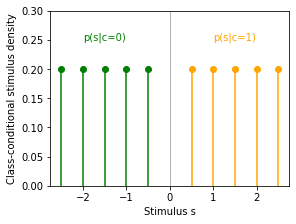

In [6]:
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)

s_vals = np.arange(0.5, 2.6, 0.5)

ax.axhline(0, color='dimgray', linewidth=0.5)
ax.axvline(0, color='dimgray', linewidth=0.5)
markerline, stemlines, baseline = ax.stem(s_vals, np.full_like(s_vals, 1/s_vals.size), basefmt='')
plt.setp(stemlines, color='orange')
plt.setp(markerline, color='orange')
plt.setp(baseline, linestyle='')
markerline, stemlines, baseline = ax.stem(-s_vals, np.full_like(s_vals, 1/s_vals.size), basefmt='')
plt.setp(stemlines, color='green')
plt.setp(markerline, color='green')
plt.setp(baseline, linestyle='')

ax.set_ylim(0,0.3)

ax.text(1.5, 0.25, 'p(s|c=1)', horizontalalignment='center', color='orange')
ax.text(-1.5, 0.25, 'p(s|c=0)', horizontalalignment='center', color='green')

ax.set_xlabel('Stimulus s')
ax.set_ylabel('Class-conditional stimulus density');

fig.savefig('ccsd_discrete.png', dpi=300)

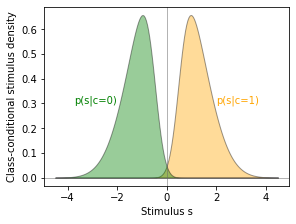

In [7]:
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
x = np.linspace(-4.5,4.5,200)

def skewed_normal(x, skewness):
    return 2*norm.pdf(x)*norm.cdf(skewness*x)

skewness = 3
ax.axhline(0, color='dimgray', linewidth=0.5)
ax.axvline(0, color='dimgray', linewidth=0.5)
ax.fill_between(x, skewed_normal(x-0.5,skewness), facecolor='orange', alpha=0.4, edgecolor='black')
ax.fill_between(x, skewed_normal(-x-0.5,skewness), color='green', alpha=0.4, edgecolor='black')
ax.text(2, 0.3, 'p(s|c=1)', horizontalalignment='left', color='orange')
ax.text(-2, 0.3, 'p(s|c=0)', horizontalalignment='right', color='green')
ax.set_xlabel('Stimulus s')
ax.set_ylabel('Class-conditional stimulus density');
fig.savefig('ccsd_skewed_gaussian.png', dpi=300)